Some setups:

In [1]:
%matplotlib inline

#Imports

In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from time import time
from copy import copy

Importing elmag module:

In [3]:
from elmagpy202.elmag import Elmag
from elmagpy202 import halo
from elmagpy202 import binbybin as bbb

##Initiate the ELMAG class with some initial setup 

Here's an example for a possible configuration (1ES0229 like). For more details see the documentation of the ElmagPy module and the default dictionary given in the defaults.py file:

In [4]:
config = {
    "model":          6, # EBL model, model 6 = Dominguez et al. (2011) model
    "ethr":           1e+8, # Energy threshold in eV below which the cascade energy losses are integrated out
    "egmax":          10e+12, # Maximum energy in eV for the injected gamma rays
    "ir_rescale":     1.00, # Rescaling of the EBL photon density
    "cohlnth":        1.00, # Coherence length of the IGMF in Mpc
    "th_jet":       1.00, # Jet opening angle in degrees
    "igmf":           1e-12, # IGMF strength in G. Note that at the moment it's not changing with z
    "emin":           1.e+8, # Minimum energy in eV of the injected photons
    "ebreak":         1.e+13, # Break energy in eV in case you want to model a broken power law (BPL)
    "gam1":           -1.7, # Spectral index below Ebreak as in dN / dE ~ E^gam1
    "gam2":           -1.7, # Spectral index above Ebreak as in dN / dE ~ E^gam2
    "iseed":           0, # Seed for the random number generation, must be an integer
    "tabledir":	      "Tables/" #path to the EBL tables provided within Elmag
    }

Init the ELMAG class. Only do this once (otherwise, restart the kernel).

In [5]:
e = Elmag(**config)

Example of how to change some model parameters during runtime. Note that you cannot change the EBL model without re-initializing the Elmag class.

In [6]:
e.igmf = 1e-15
e.gam1 = config['gam1']
e.gam1 = config['gam2']
e.ebreak = 31.6227e12
e.egmax = 31.6227e12
e.emin = 1e8
e.n_bine = int(np.log10(e.egmax / e.emin) * 8 + 2) # Set to 8 bins per decade, with left bin boundary aligned with 1 GeV
e.set_params()

Set up the result arrays. Note that these have to be re-initialized each time you run the cascade. Otherwise the new runs will also be added to the histograms.

In [7]:
e.set_result_arrays()

#Run the cascade simulation

In [8]:
z = 0.14 # source redshift 
nmax = 1e4 # number of injected particles
e.egdelta = 1e10
t0 = time() # measure the time it takes
for i in range(int(nmax)):
    e.initial_particle(distr = 'elmag') # initiate a particle. For a delta distribution select distr = 'delta'.
                                        # In this case the particle energy is given by e.egmax
    e.save_initial_particle(z) # save the initial particle to the e.init_hist distribution
    e.cascade(z) # run the cascade for one particle

    

print 'it took ',time() - t0, 's'
e.get_results() # get the results and save them to the np arrays

it took  54.5901191235 s


Make some copies for the comparison to the bin-by-bin results later:

In [9]:
cascF = copy(e.hist_eth[:,1:].sum(axis = 1))
primF = copy(e.hist_eth[:,0])
gam = copy(e.gam1)

#Plot some results

###Plot the spectrum:

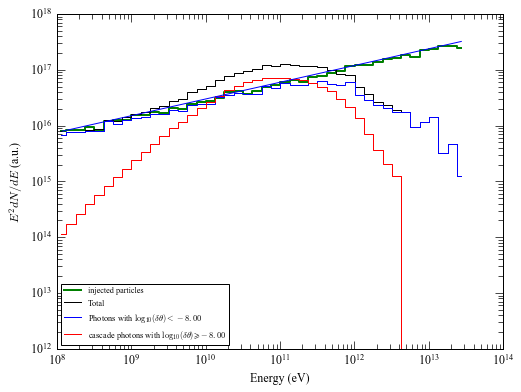

In [10]:
plt.figure(figsize = (8,6))
ax = plt.subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')

#e.EeV_lbounds contains the left bin boundaries of energy
#e.hist_eth gives the 2d histogram of E^2 dN / dE cascade photons
#first axis: energy bins, second axis: angular separation, bins are given in e.th_lbounds

# injected particle spectrum
plt.plot(e.EeV , e.init_hist * e.EeV, 
         color = 'g',drawstyle = 'steps-mid', # this is the same as with errorbars on x since we plot the bin centers
        label = 'injected particles', lw = 2)

# output particle spectra
plt.plot(e.EeV, e.hist_eth.sum(axis = 1) * e.EeV,
         color = 'k',drawstyle = 'steps-mid',
         label = r'Total')
plt.plot(e.EeV, e.hist_eth[:,0]  * e.EeV,
         color = 'b',drawstyle = 'steps-mid',
        label = r'Photons with $\log_{{10}}(\delta\theta) < {0:.2f}$'.format(e.th_lbounds[0]))
plt.plot(e.EeV, e.hist_eth[:,1:].sum(axis = 1) * e.EeV,
         color = 'r',drawstyle = 'steps-mid',
         label = r'cascade photons with $\log_{{10}}(\delta\theta) \geqslant {0:.2f}$'.format(e.th_lbounds[0]))

#plt.plot(e.EeV, 3e6 * np.power(e.EeV / 1e10, e.gam1 + 1))
plt.plot(e.EeV, 3e16 * np.power(e.EeV / 1e10, e.gam1 + 2))
plt.legend(loc = 0, fontsize = 'small')

v = np.array(plt.axis())
#v[-2] = v[-1] / 1e3
#v[-1] /= 5
v[-2] = v[-1] / 1e6
plt.axis(v)
#plt.axis([5e8,5e10,1e14,5e16])
plt.xlabel('Energy (eV)')
plt.ylabel('$E^2 dN / dE$ (a.u.)')

###Calculate a containment radius

68.0 containment radius: 0.35 degrees


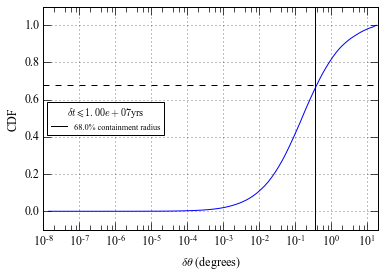

In [11]:
tmax = 1e7 # maximum time delay in years
conf = 0.68 # containment level
emin = 1e9 # min energy in eV
emax = None # max energy in eV
r = halo.calc_conf_radius(e.hist_etht, e.th, conf, 
                          tmax = tmax, t_lbounds= e.t_lbounds, 
                          emin = emin,
                          emax = emax,
                          e_lbounds = e.EeV_lbounds,
                          interp = False
                         )

print "{0:.1f} containment radius: {1:.2f} degrees".format(conf * 100,r)
# do the plot:
if not tmax == None:
    idt = np.where(e.t_lbounds <= np.log10(tmax))[0][-1] # choose a maximum time delay
    hist = e.hist_etht[:,1:,:idt+1].sum(axis = 2) # on first axis exclude primary component
else:
    hist = e.hist_etht[:,1:,:].sum(axis = 2) # on first axis exclude primary component

if not emax == None:
    ide  = np.where(e.EeV_lbounds <= emax)[0][-1] # choose a maximum energy
    hist = hist[ :ide+1 if ide <= hist.shape[0] else None ,:]
if not emin == None:
    ide  = np.where(e.EeV_lbounds >= emin)[0][0] # choose a minimum energy
    hist = hist[ide:,:]

plt.semilogx(e.th[1:], np.cumsum(hist.sum(axis = 0)) / hist.sum() )

plt.axvline(r, color = 'k', label = '{0:.1f}% containment radius'.format(conf*100))
plt.axhline(conf, color = 'k', ls = '--')

plt.legend(loc = 'center left', fontsize = 'small', title = '$\delta t \,\leqslant\, {0:.2e}$yrs'.format(
                tmax if not tmax == None else e.t_lbounds[-1]))

plt.ylabel('CDF')
plt.xlabel(r'$\delta\theta$ (degrees)')
v = np.array(plt.axis())
v[1],v[2], v[3] = 2e1,-0.1,1.1
plt.axis(v)
plt.grid(True)

###Plot the surface brightness profile

Plot the intensity $dN / dEd\theta^2$ for all energy bins 

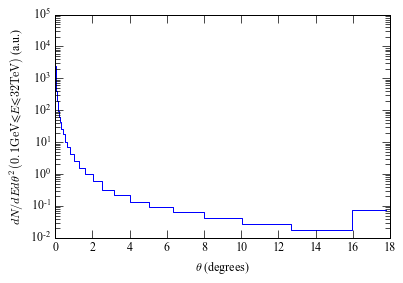

In [12]:
ax = plt.subplot(111)
#ax.set_xscale('log')
ax.set_yscale('log')

# intenisity
# divide E dN / dE histogram by E and then by solid angle of each bin to get
# dN / dE / dtheta^2
plt.plot(e.th, 
        (e.hist_eth.T / e.EeV).T.sum(axis = 0) / \
         (10.**(2. * e.th_lbounds[1:]) - 10.**(2.*e.th_lbounds[:-1])) / np.pi / np.pi**2. * 180.**2.,
        drawstyle = 'steps-mid'
        )

v = np.array(plt.axis())
v[-1] = 1e5
v[-2] = 1e-2
plt.axis(v)
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$dN/dEd\theta^2\,({0:.1f}\mathrm{{GeV}}\leqslant E \leqslant {1:.0f}\mathrm{{TeV}})$ (a.u.)'.format(
    e.ethr / 1e9, e.egmax / 1e12
    ))

###Plot the 2d histograms of $E^2dN / dE$ for different maximum time delays

Use the 3d histogram e.hist_etht with 0th axis energy, 1st axis $\delta\theta$ and third axis $\delta t$

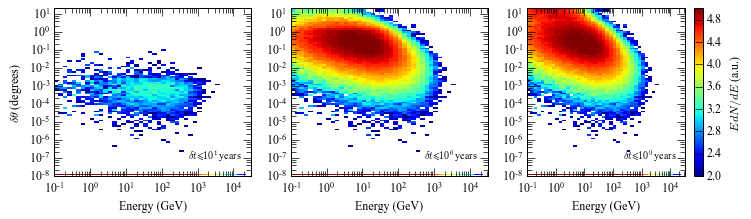

In [13]:
plt.figure(figsize = (12,3))
ee,tt = np.meshgrid(e.EeV_lbounds, e.th)
cp = plt.cm.jet
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    vmin, vmax = 2,5
    
    if not i:  
        idt = np.where(e.t_lbounds <= 1.)[0][-1]
        Z = e.hist_etht[:,:,:idt+1].sum(axis = 2)
        tstring = '$\delta t \leqslant 10^{0:.0f}\,$years'.format(e.t_lbounds[idt])
        plt.ylabel(r'$\delta\theta$ (degrees)')
    elif i == 1: 
        idt = np.where(e.t_lbounds <= 6.)[0][-1]
        Z = e.hist_etht[:,:,:idt+1].sum(axis = 2)
        tstring = '$\delta t \leqslant 10^{0:.0f}\,$years'.format(e.t_lbounds[idt])
    else: 
        Z = e.hist_etht.sum(axis = 2)
        plt.colorbar(im, label = '$E\,dN/dE$ (a.u.)')
        tstring = '$\delta t \leqslant 10^{0:.0f}\,$years'.format(e.t_lbounds[-1]) 
        
    im = plt.pcolormesh(ee / 1e9,tt,np.log10(Z).T,
                  cmap = cp,
                  vmin = vmin,
                  vmax = vmax,
                  )
    
    plt.annotate(tstring, xy = (0.95,0.1), ha = 'right', xycoords = 'axes fraction')
    plt.xlabel('Energy (GeV)')
        
    cp.set_under('1.')

    plt.axis([e.EeV_lbounds[0]/1e9,e.EeV_lbounds[-1]/1e9,10.**e.th_lbounds[0],10.**e.th_lbounds[-1]])

##Run a bin-by-bin simulation

Run the cascade for each energy bin:

In [14]:
z = 0.14 # source redshift 
nmax = 1e2 # number of injected particles for weight = 1
binByBinCasc = np.ones((e.EeV.shape[0],     # true energy axis
                        e.EeV.shape[0],     # obs energy axis
                        e.n_binth,  # angular separation axis
                        e.n_bint,   # time delay axis
                        )) * e.replaceZero
binByBinInit = np.ones(e.EeV.shape[0]) * e.replaceZero # results for injected photons


t0 = time()
for i,E in enumerate(e.EeV): # run the cascade for each energy bin
    e.set_result_arrays()
    # weight the high energy bins (i.e. inject more high energy photons). 
    # Only use this line if you have the eblstud package installed. 
    e.bin_by_bin_cascade(z,nmax, ibin = i, ebl_weight=4)
    # Otherwise use this line:
    #e.bin_by_bin_cascade(z,nmax, ibin = i)
    binByBinCasc[i] = e.hist_etht
    binByBinInit[i] = e.init_hist.sum()
print 'it took ',time() - t0, 's'

it took  88.2256309986 s


###Plot the output

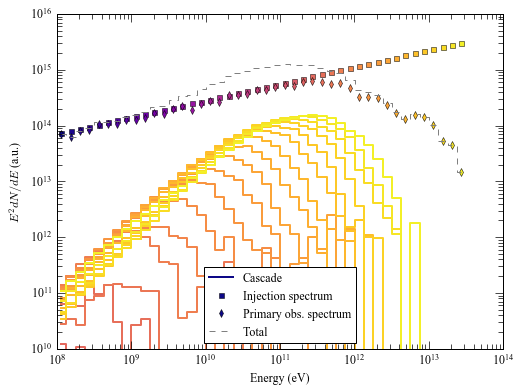

In [15]:
plt.figure(figsize = (8,6))
ax = plt.subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')
cp = plt.cm.plasma


for i,b in enumerate(binByBinCasc):
    plt.plot(e.EeV , b[:,1:,1:].sum(axis = 2).sum(axis = 1) * e.EeV, 
        drawstyle = 'steps-mid', lw = 2, color = cp(i / float(e.EeV.shape[0])),
            label = '' if i else 'Cascade')
    
    plt.plot(e.EeV[i] , 
        binByBinInit[i] * e.EeV[i],
        ls = 'none', marker = 's', ms = 5,
        lw = 2, color = cp(i / float(e.EeV.shape[0])),
            label = '' if i else 'Injection spectrum')
    

for i,b in enumerate(binByBinCasc[:,:,0,0].sum(axis = 0)):
    plt.plot(e.EeV[i] ,      
        b * e.EeV[i], 
        ls = 'None', marker = 'd', ms = 5,
        lw = 2, color = cp(i / float(e.EeV.shape[0])),
            label = '' if i else 'Primary obs. spectrum')
    
plt.plot(e.EeV , 
         binByBinCasc.sum(axis = 3).sum(axis = 2).sum(axis = 0) * e.EeV, 
         color = '0.5',
         drawstyle = 'steps-mid', lw = 1, ls = '--',
        label = 'Total')

plt.legend(loc = 'lower center')
v = np.array(plt.axis())
v[-2] = v[-1] / 1e6
plt.axis(v)
plt.xlabel('Energy (eV)')
plt.ylabel('$E^2 dN / dE$ (a.u.)')
plt.savefig('cascade_example.png', format = 'png', dpi = 200)

In [16]:
%load_ext autoreload

In [17]:
%autoreload 2

###The 68% containment radius for a time cut and for different maximal injected energies

Apply a time cut to the bin-by-bin output:

In [18]:
tmax = 1e7 # max time delay in years
bbbTcut = bbb.apply_time_cut(binByBinCasc, e.t_lbounds,tmax)

Calculate the containment radius for some confidence level. The output is a matrix, first axis for maximum injection energies, second axis for central energy of the particular energy bin.

In [19]:
r = bbb.calc_cont_radius_2d(bbbTcut,e.EeV_lbounds,e.th,conf = 0.68, interp = True)

elmagpy202/halo.py:76: RuntimeWarning: All entries smaller than 1e-10. No cascade photons? Retuning 0.
  warnings.warn("All entries smaller than 1e-10. No cascade photons? Retuning 0.",RuntimeWarning)


Plot the output:

/Library/Python/2.7/site-packages/ipython-3.2.0-py2.7.egg/IPython/kernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


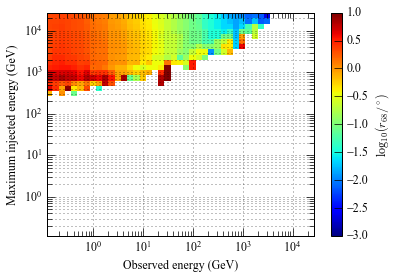

In [20]:
ee,EE = np.meshgrid(e.EeV / 1e9, e.EeV / 1e9)
cp = plt.cm.jet

vmax = 1.
vmin = -3.
ax = plt.subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')
im = plt.pcolormesh(ee,EE,np.log10(r),
                  cmap = cp,
                  vmin = vmin,
                  vmax = vmax,
                  )
plt.colorbar(im, label = '$\log_{10}(r_{68} / {}^\circ)$')
#cp.set_under('1.')
plt.xlabel('Observed energy (GeV)')
plt.ylabel('Maximum injected energy (GeV)')
plt.axis(np.array([e.EeV[0],e.EeV[-1],e.EeV[0],e.EeV[-1]])/1e9)
plt.grid(which = 'both', axis = 'y')
plt.grid(which = 'major', axis = 'x')